<a href="https://colab.research.google.com/github/kujoki/ML_ITMO_course/blob/main/more_complex_model_and_interpret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna > None

In [ ]:
!pip install catboost > None
!pip install xgboost > None

In [ ]:
!pip install shap > None

In [ ]:
import pandas as pd
import numpy as np
import datetime
from itertools import combinations

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

import plotly.express as px
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
import folium
import matplotlib.pyplot as plt

import optuna
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
import calendar

In [ ]:
import shap
from sklearn.inspection import permutation_importance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML_ITMO/hotel_bookings_more_columns.csv')

EDA: Разведочный анализ данных

In [ ]:
df.shape

(119390, 32)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

На всякий случай сразу удаляем строки, которые дублируют друг друга. 

In [ ]:
df = df.drop_duplicates()

Определение нулевых значений в наблюдаемых признаках - при слишком высоком проценте отствующих значений происходит удаление признака из списка предикторов. 

In [ ]:
pd.DataFrame({'Null' : df.isna().sum(), 'Percentage of Null' : (df.isna().sum()) / (df.shape[0]) * (100)})

,Null,Percentage of Null
hotel,0,0.000000
is_canceled,0,0.000000
lead_time,0,0.000000
arrival_date_year,0,0.000000
arrival_date_month,0,0.000000
arrival_date_week_number,0,0.000000
arrival_date_day_of_month,0,0.000000
stays_in_weekend_nights,0,0.000000
stays_in_week_nights,0,0.000000
adults,0,0.000000


Удаляем столбец company - слишком много пропусков

In [ ]:
df = df.drop(columns = ['company']) 

Далее удаляем выбросы - в случае если в одном наблюдении нет ни одного постояльца в отеле - удалем наблюдение

In [ ]:
df = df[~((df.children == 0) & (df.adults == 0) & (df.babies == 0))]

In [ ]:
df.shape # ранее 119390

(87230, 31)

Теперь посмотрим, из какой страны приехало самое большое количество постояльцев. Скорее всего признак country будет удален, так как он имеет слишком большую размерность). Однако если графики для всего датасета и для части датасета, где целевая целевая метка равна нулю, будут сильно отличатся, то этот признак будет сохранен. 

In [ ]:
df['no_of_visitors'] = df.children + df.adults + df.babies

In [ ]:
num_of_visitors_country = df.groupby('country').agg('sum').no_of_visitors.reset_index()

In [ ]:
num_of_visitors_country

,country,no_of_visitors
0,ABW,5.0
1,AGO,628.0
2,AIA,4.0
3,ALB,21.0
4,AND,19.0
...,...,...
172,VGB,2.0
173,VNM,17.0
174,ZAF,156.0
175,ZMB,6.0


График зависимости числа постояльцев от места прибывания (для всего датасета)

In [ ]:
fig = px.choropleth(num_of_visitors_country, locations='country', color='no_of_visitors',
                           color_continuous_scale="Viridis",
                           scope="world",
                           labels={'no_of_visitors':'number_of_visitors'}
                          )
fig.show()

In [ ]:
num_of_visitors_country = df[df['is_canceled'] == 0].groupby('country').agg('sum').no_of_visitors.reset_index()

In [ ]:
num_of_visitors_country.shape

(165, 2)

График зависимости числа постояльцев от места прибывания для части датасета, в которой было ли бронирование не отменено (0)

In [ ]:
fig = px.choropleth(num_of_visitors_country, locations='country', color='no_of_visitors',
                           color_continuous_scale="Viridis",
                           scope="world",
                           labels={'no_of_visitors':'number_of_visitors'}
                          )
fig.show()

Не смотря на то, что интенсивнось цветовой палитры графика 1 и графика 2 выглядит одинаково, количество постоятельцев на графике 2 уменьшилось (видно при наведении курсора на область карты или при внимальном рассмотрении шкалы интенсивности цвета справа справа).
На основании графика можно сделать вывод о том, что в датасете наибольшее число постояльцев прибыло из европейских стран (Португалия, Испания, Франция, Англия, Италия, Германия)

Зависимость целевой метки от типа забронированной комнаты и среднедневного тарифа.
Среднедневной тариф определяется путем деления суммы всех операций с жильем на общее количество ночей проживания.

In [ ]:
px.box(data_frame = df, x = 'reserved_room_type', y = 'adr', color = 'is_canceled', template = 'plotly')

In [ ]:
df[df.adr == 5400]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,no_of_visitors
48515,City Hotel,1,35,2016,March,13,25,0,1,2,...,Non Refund,12.0,0,Transient,5400.0,0,0,Canceled,2016-02-19,2.0


Удаляем предположительный выброс из данных для удобства отображения.

In [ ]:
px.box(data_frame = df[~(df.adr == 5400)], x = 'reserved_room_type', y = 'adr', color = 'is_canceled', template = 'plotly')

Диаграммы размаха выглядят почти идентично при разных значениях целевой метик. Но для комнат типа L медианное значение среднедневного тарифа существенно выше для наблюдений с не отмененной бронью, чем для наблюдений с отмененной бронью. 

Несколько настораживает, что для некоторых комнат минимальное значение среднедневного тарифа равно нулю - такое может быть если общая сумма за проживание равна нулю. Было бы логично, если бы такие значения встречались только при отмене бронирования, но тут такие значения могут быть и при сохранении брони.

In [ ]:
df['adr'].describe()

count    87230.000000
mean       106.518031
std         54.891227
min         -6.380000
25%         72.250000
50%         98.200000
75%        134.100000
max       5400.000000
Name: adr, dtype: float64

Из описательной статистики для признака среднедневного тарифа видно, что минимальное значение равно -6. Этот явный выброс необходимо удалить.

In [ ]:
df = df[~(df['adr'] < 0)]

Форматирование дат в виде значений datetime

In [ ]:
df['arrival_date_month'].value_counts()

August       11242
July         10043
May           8344
April         7900
June          7756
March         7488
October       6921
September     6682
February      6083
December      5112
November      4973
January       4685
Name: arrival_date_month, dtype: int64

In [ ]:
def month_string_to_number(string):
    dict_of_months = {month: index for index, month in enumerate(calendar.month_abbr) if month}
    s = string.strip()[:3]
    return dict_of_months[s]

In [ ]:
df['arrival_date_month_int'] = df['arrival_date_month'].apply(lambda x: month_string_to_number(x))

In [ ]:
datetime.date(df['arrival_date_year'][0], df['arrival_date_month_int'][0], df['arrival_date_day_of_month'][0])

datetime.date(2015, 7, 1)

In [ ]:
def transform_to_datetime(x):
    try:
        result = datetime.date(x['arrival_date_year'] , x['arrival_date_month_int'], x['arrival_date_day_of_month'])
    except ValueError:
        result = datetime.date(x['arrival_date_year'] , x['arrival_date_month_int'], (x['arrival_date_day_of_month']-1))
    return (result)

In [ ]:
df['year_month_day'] = df.apply(lambda x: transform_to_datetime(x), axis=1)

In [ ]:
canceled = df[df["is_canceled"]== 0].groupby("year_month_day").no_of_visitors.sum()
not_canceled = df[df["is_canceled"]== 1].groupby("year_month_day").no_of_visitors.sum()

all_data = pd.concat([canceled, not_canceled], axis=1)
all_data.columns = ['canceled', 'not_canceled']
all_data = all_data.fillna(0)

In [ ]:
px.line(all_data)

На основе этого графика можно сделать вывод, что за исключением редких дат,  количество постояльцев, которые не отмененили свою бронь, ниже, чем количество постояльцев, которые бронь сохранили. Этот график достаточно хорош в плане наблюдения за сезонностью временного ряда (общее количество бронирования возрастает летом и убывает зимой - только 5 декабря 2015 года было что-то странное). 

В датасете представлены два типа отелей. Посмотрим, как распределяются постояльцы в зависимости от типа отеля. 

In [ ]:
df.hotel.value_counts()

City Hotel      53274
Resort Hotel    33955
Name: hotel, dtype: int64

In [ ]:
no_visit_city_hotel = df[df["hotel"]== 'City Hotel'].groupby("year_month_day").no_of_visitors.sum()
no_visit_resort_hotel = df[df["hotel"]== 'Resort Hotel'].groupby("year_month_day").no_of_visitors.sum()

temp_hotel_data = pd.concat([no_visit_city_hotel, no_visit_resort_hotel], axis=1)
temp_hotel_data.columns = ['visit_in_city_hotel', 'visit_in_resort_hotel']
temp_hotel_data = temp_hotel_data.fillna(0)

In [ ]:
px.line(temp_hotel_data)

На основании выше представленного графика сложно сделать вывод об особенностях распределения. 

Наиболее популярные месяцы для бронирования в каждом отеле

In [ ]:
def make_new_temp_data(df, name_of_hue_column, name_of_groupby_column, name_of_agg_column, agg_func):
  column_type_1, column_type_2 = df[f'{name_of_hue_column}'].unique()[0], df[f'{name_of_hue_column}'].unique()[1]
  temp_1 = df[df[f"{name_of_hue_column}"]== f'{column_type_1}'].groupby(f"{name_of_groupby_column}")[f'{name_of_agg_column}'].agg([f'{agg_func}'])
  temp_2 = df[df[f"{name_of_hue_column}"]== f'{column_type_2}'].groupby(f"{name_of_groupby_column}")[f'{name_of_agg_column}'].agg([f'{agg_func}'])

  temp_data = pd.concat([temp_1, temp_2], axis=1)
  temp_data.columns = [f'{name_of_agg_column}_by_{column_type_1}', f'{name_of_agg_column}_by_{column_type_2}']
  return temp_data.fillna(0)

In [ ]:
make_new_temp_data(df, 'hotel', 'arrival_date_month', 'no_of_visitors', 'sum')

,no_of_visitors_by_Resort Hotel,no_of_visitors_by_City Hotel
arrival_date_month,,
April,5469.0,10594.0
August,10914.0,14722.0
December,4055.0,6210.0
February,4752.0,7095.0
January,3467.0,5134.0
July,9879.0,12743.0
June,5810.0,10024.0
March,4882.0,9454.0
May,5869.0,10490.0


In [ ]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
temp_hotel_data_month = make_new_temp_data(df, 'hotel', 'arrival_date_month', 'no_of_visitors', 'sum').reindex(new_order, axis=0)

In [ ]:
px.line(temp_hotel_data_month)

На основании этого графика можно сделать вывод о том, что посетителей в City hotel стабильно больше. Особенно разрыв становится большим в весенние месяцы.

In [ ]:
make_new_temp_data(df, 'hotel', 'arrival_date_month', 'adr', 'mean')

,adr_by_Resort Hotel,adr_by_City Hotel
arrival_date_month,,
April,79.283805,117.314134
August,187.566659,125.148662
December,65.488671,93.204767
February,54.102809,89.266427
January,49.181693,85.269875
July,156.166914,120.318314
June,112.380859,123.996416
March,57.614983,95.193911
May,80.551101,128.055724


Суточная стоимость проживания в зависимости от месяца и отеля

In [ ]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
temp_hotel_adr_month = make_new_temp_data(df, 'hotel', 'arrival_date_month', 'adr', 'mean').reindex(new_order, axis=0)

In [ ]:
px.line(temp_hotel_adr_month)

Средняя стоимость проживания в Resort отеле увеличиватся в летние месяцы - на август приходятся максимальные значения. Для зимних, весенних и осенних месяцев - среднее стоимость проживания выше в City hotel

Корреляция предикторов между собой. Корреляция между предикторами и целевой меткой


In [ ]:
df.corr()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,no_of_visitors,arrival_date_month_int
is_canceled,1.000000,0.184527,0.088029,0.001682,0.005440,0.061016,0.084172,0.080272,0.067207,-0.020628,...,0.051500,-0.052171,-0.093223,-0.044659,0.004710,0.127221,-0.184459,-0.120800,0.098973,0.003946
lead_time,0.184527,1.000000,0.139393,0.101316,0.009918,0.236285,0.312488,0.139032,0.028389,-0.003704,...,0.005372,-0.079038,0.080788,0.023335,0.131911,0.021980,-0.086733,0.034061,0.125279,0.106342
arrival_date_year,0.088029,0.139393,1.000000,-0.513887,-0.009856,0.005239,0.003743,0.038742,0.041161,-0.023365,...,-0.054283,0.027252,0.008912,-0.020365,-0.027489,0.176627,-0.040038,0.064222,0.050929,-0.499524
arrival_date_week_number,0.001682,0.101316,-0.513887,1.000000,0.093258,0.027508,0.028522,0.025325,0.013543,0.014301,...,0.007037,-0.020923,0.012978,0.017844,0.013158,0.099067,0.009050,0.046747,0.029798,0.995079
arrival_date_day_of_month,0.005440,0.009918,-0.009856,0.093258,1.000000,-0.017596,-0.028352,-0.001233,0.015808,-0.000398,...,-0.008554,0.000163,0.007041,0.008760,0.006087,0.022654,0.009036,-0.001689,0.008126,0.000400
stays_in_weekend_nights,0.061016,0.236285,0.005239,0.027508,-0.017596,1.000000,0.550451,0.091448,0.028919,0.013806,...,-0.020639,-0.056929,0.034545,0.127566,-0.031979,0.040488,-0.042971,0.032846,0.090660,0.027740
stays_in_week_nights,0.084172,0.312488,0.003743,0.028522,-0.028352,0.550451,1.000000,0.099321,0.030940,0.016203,...,-0.018694,-0.058735,0.066382,0.166127,0.001856,0.055125,-0.044479,0.038352,0.098357,0.032498
adults,0.080272,0.139032,0.038742,0.025325,-0.001233,0.091448,0.099321,1.000000,0.022181,0.016237,...,-0.042389,-0.122108,-0.036453,-0.039121,-0.014924,0.242006,0.007015,0.112512,0.801988,0.028112
children,0.067207,0.028389,0.041161,0.013543,0.015808,0.028919,0.030940,0.022181,1.000000,0.017368,...,-0.019210,-0.029444,0.033413,0.027903,-0.020372,0.326358,0.036262,0.044510,0.597403,0.013741
babies,-0.020628,-0.003704,-0.023365,0.014301,-0.000398,0.013806,0.016203,0.016237,0.017368,1.000000,...,-0.005394,-0.009198,0.083431,0.035192,-0.006825,0.023205,0.030873,0.094857,0.166711,0.014154


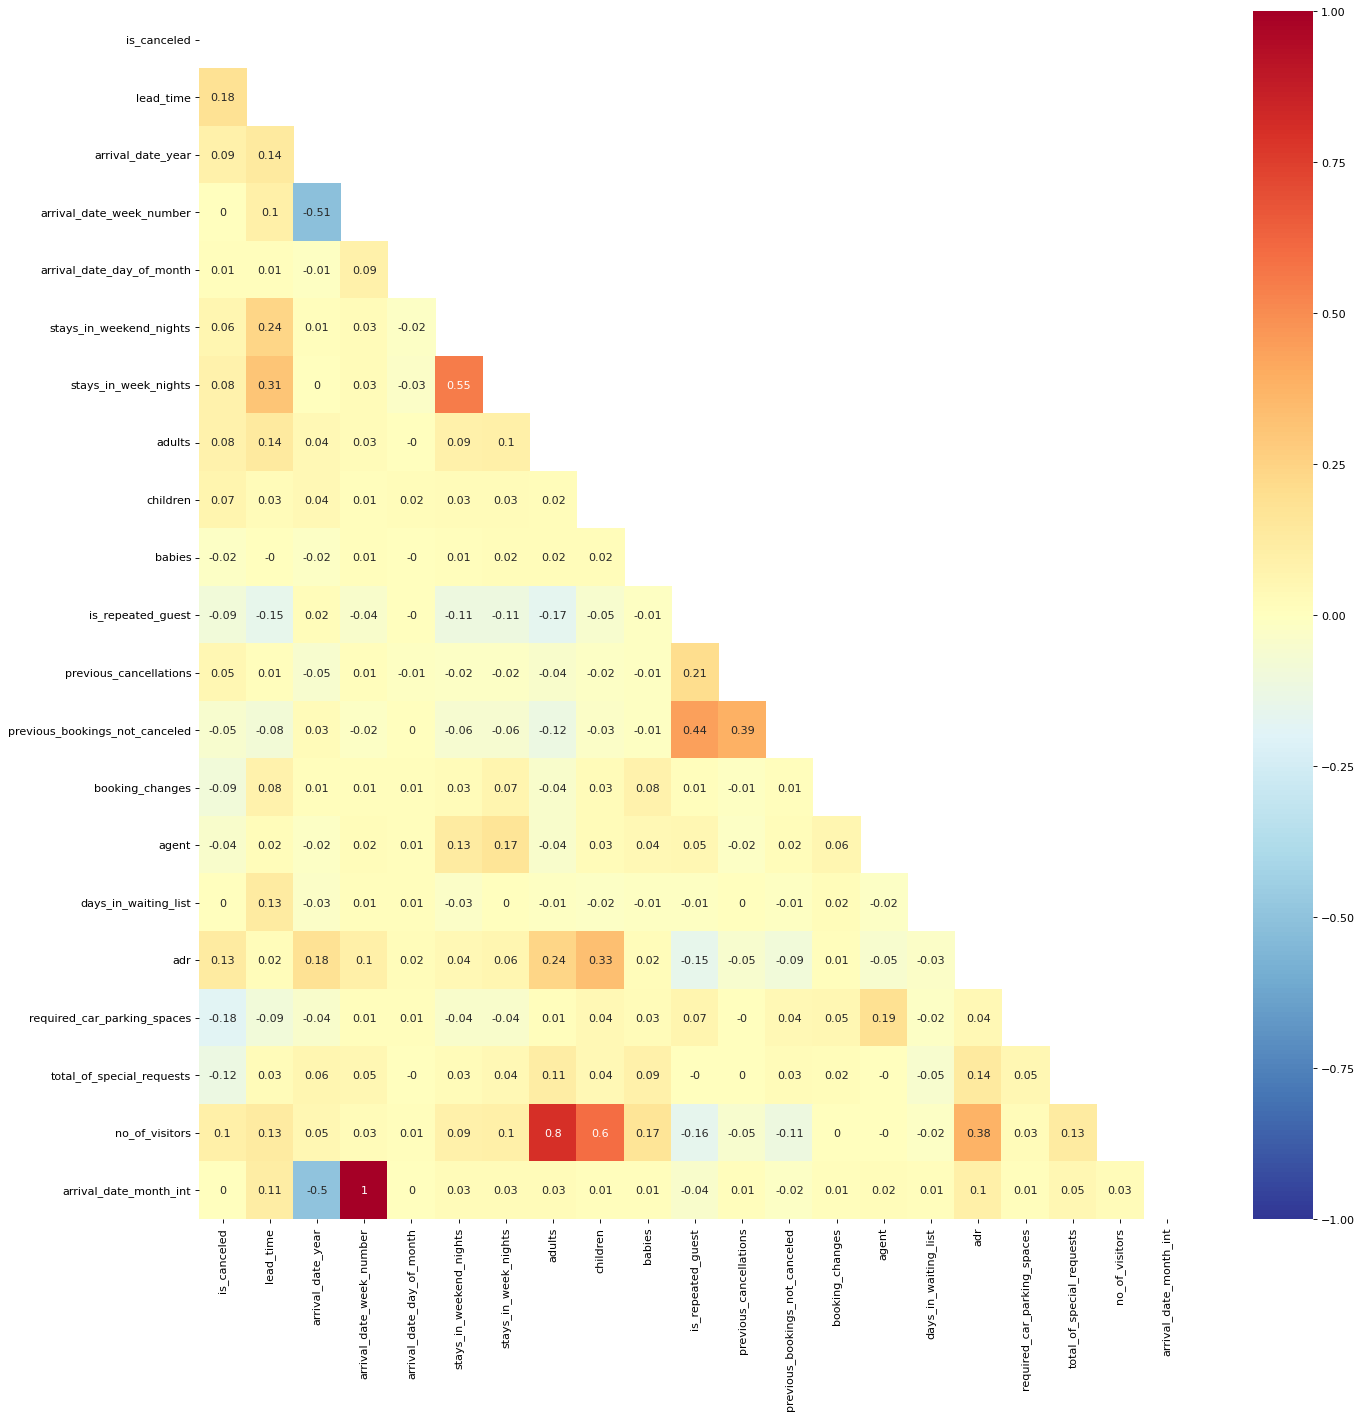

In [ ]:
figure(figsize=(20, 20), dpi=80)

# calculate the correlation matrix
matrix = df.corr().round(2)

mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='RdYlBu_r', mask=mask)
plt.show()

Сортировка по значению корреляции

In [ ]:
upper_corr_mat = matrix.where(
    np.triu(np.ones(matrix.shape), k=1).astype(np.bool))
  
# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# Sort correlation pairs
sorted_mat = unique_corr_pairs.abs().sort_values(ascending = False)
print(sorted_mat)


arrival_date_month_int          arrival_date_week_number     1.00
no_of_visitors                  adults                       0.80
                                children                     0.60
stays_in_week_nights            stays_in_weekend_nights      0.55
arrival_date_week_number        arrival_date_year            0.51
                                                             ... 
total_of_special_requests       arrival_date_day_of_month    0.00
previous_bookings_not_canceled  arrival_date_day_of_month    0.00
required_car_parking_spaces     previous_cancellations       0.00
days_in_waiting_list            previous_cancellations       0.00
                                is_canceled                  0.00
Length: 210, dtype: float64


<ipython-input-49-ccacd78f4cf8>:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
matrix.unstack().abs()

is_canceled             is_canceled                    1.00
                        lead_time                      0.18
                        arrival_date_year              0.09
                        arrival_date_week_number       0.00
                        arrival_date_day_of_month      0.01
                                                       ... 
arrival_date_month_int  adr                            0.10
                        required_car_parking_spaces    0.01
                        total_of_special_requests      0.05
                        no_of_visitors                 0.03
                        arrival_date_month_int         1.00
Length: 441, dtype: float64

In [ ]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

matrix.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())


<ipython-input-51-b554327d349e>:15: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,no_of_visitors,arrival_date_month_int
is_canceled,1.00,0.18,0.09,0.00,0.01,0.06,0.08,0.08,0.07,-0.02,-0.09,0.05,-0.05,-0.09,-0.04,0.00,0.13,-0.18,-0.12,0.10,0.00
lead_time,0.18,1.00,0.14,0.10,0.01,0.24,0.31,0.14,0.03,-0.00,-0.15,0.01,-0.08,0.08,0.02,0.13,0.02,-0.09,0.03,0.13,0.11
arrival_date_year,0.09,0.14,1.00,-0.51,-0.01,0.01,0.00,0.04,0.04,-0.02,0.02,-0.05,0.03,0.01,-0.02,-0.03,0.18,-0.04,0.06,0.05,-0.50
arrival_date_week_number,0.00,0.10,-0.51,1.00,0.09,0.03,0.03,0.03,0.01,0.01,-0.04,0.01,-0.02,0.01,0.02,0.01,0.10,0.01,0.05,0.03,1.00
arrival_date_day_of_month,0.01,0.01,-0.01,0.09,1.00,-0.02,-0.03,-0.00,0.02,-0.00,-0.00,-0.01,0.00,0.01,0.01,0.01,0.02,0.01,-0.00,0.01,0.00
stays_in_weekend_nights,0.06,0.24,0.01,0.03,-0.02,1.00,0.55,0.09,0.03,0.01,-0.11,-0.02,-0.06,0.03,0.13,-0.03,0.04,-0.04,0.03,0.09,0.03
stays_in_week_nights,0.08,0.31,0.00,0.03,-0.03,0.55,1.00,0.10,0.03,0.02,-0.11,-0.02,-0.06,0.07,0.17,0.00,0.06,-0.04,0.04,0.10,0.03
adults,0.08,0.14,0.04,0.03,-0.00,0.09,0.10,1.00,0.02,0.02,-0.17,-0.04,-0.12,-0.04,-0.04,-0.01,0.24,0.01,0.11,0.80,0.03
children,0.07,0.03,0.04,0.01,0.02,0.03,0.03,0.02,1.00,0.02,-0.05,-0.02,-0.03,0.03,0.03,-0.02,0.33,0.04,0.04,0.60,0.01
babies,-0.02,-0.00,-0.02,0.01,-0.00,0.01,0.02,0.02,0.02,1.00,-0.01,-0.01,-0.01,0.08,0.04,-0.01,0.02,0.03,0.09,0.17,0.01


Корреляция предикторов и целевой метки - в порядке убывания

In [ ]:
correlation = df.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

is_canceled                       1.000000
lead_time                         0.184527
required_car_parking_spaces       0.184459
adr                               0.127221
total_of_special_requests         0.120800
no_of_visitors                    0.098973
booking_changes                   0.093223
is_repeated_guest                 0.088741
arrival_date_year                 0.088029
stays_in_week_nights              0.084172
adults                            0.080272
children                          0.067207
stays_in_weekend_nights           0.061016
previous_bookings_not_canceled    0.052171
previous_cancellations            0.051500
agent                             0.044659
babies                            0.020628
arrival_date_day_of_month         0.005440
days_in_waiting_list              0.004710
arrival_date_month_int            0.003946
arrival_date_week_number          0.001682
Name: is_canceled, dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87229 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87229 non-null  object 
 1   is_canceled                     87229 non-null  int64  
 2   lead_time                       87229 non-null  int64  
 3   arrival_date_year               87229 non-null  int64  
 4   arrival_date_month              87229 non-null  object 
 5   arrival_date_week_number        87229 non-null  int64  
 6   arrival_date_day_of_month       87229 non-null  int64  
 7   stays_in_weekend_nights         87229 non-null  int64  
 8   stays_in_week_nights            87229 non-null  int64  
 9   adults                          87229 non-null  int64  
 10  children                        87225 non-null  float64
 11  babies                          87229 non-null  int64  
 12  meal                           

Я планирую удалить все признаки, связанные с датой, кроме year_month_day (это признак в формате datetime, с ним будет удобно работать). Признаки связанные с датой имеют высокий уровень корреляции между друг другом - это ведет к бессмысленному расширению признакового пространства. Также эти признаки имеют низкий уровень корреляции с целевой меткой. 


Кроме того, будет удален признак days_in_waiting_list из-за отстувия корреляции с целевой меткой. 


Также будут удалены признаки reservation_status, reservation_status_date, country. 

reservation_status или последний статус бронирования предполагает одну из трех категорий: Canceled - бронирование было отменено клиентом; Check-Out - клиент зарегистрировался, но уже уехал; No-Show - клиент не зарегистрировался и не сообщил отелю о причине. 

In [ ]:
df = df.drop(columns = ['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_year', 'arrival_date_month_int',
               'reservation_status', 'country', 'days_in_waiting_list'])

In [ ]:
df = df.drop(columns = ['reservation_status_date'])

Определение категориальных столбцов и количества уникальных значений в каждом

In [ ]:
for name in df.columns.tolist():
    if df[name].dtype == 'O':
        print (f'Name of feature = {name}, unique values: {df[name].nunique()}')

Name of feature = hotel, unique values: 2
Name of feature = meal, unique values: 5
Name of feature = market_segment, unique values: 8
Name of feature = distribution_channel, unique values: 5
Name of feature = reserved_room_type, unique values: 9
Name of feature = assigned_room_type, unique values: 11
Name of feature = deposit_type, unique values: 3
Name of feature = customer_type, unique values: 4
Name of feature = year_month_day, unique values: 793


Так как типов комнат достаточно много (для OneHotEncoding) - добавим новый признак, который будет отражать соотвествие reserved_room_type и assigned_room_type. Если reserved_room_type = assigned_room_type, то значение признака 1, в противном случае 0. 

In [ ]:
df['desired_Room'] = np.where(df['reserved_room_type'] == df['assigned_room_type'], 1, 0)

In [ ]:
df = df.drop(columns = ['reserved_room_type', 'assigned_room_type'])

Предобработка

Обозначение сегмента рынка. В категориях термин "ТА" означает "Турагенты", а "ТО" - "Туроператоры". Значения признака Undefined планирую заменить наиболее распространенным значение признака, а дальше... наверное get_dummies

In [ ]:
df.market_segment.value_counts()

Online TA        51553
Offline TA/TO    13855
Direct           11780
Groups            4921
Corporate         4200
Complementary      692
Aviation           226
Undefined            2
Name: market_segment, dtype: int64

Тип заказанного питания. Категории представлены в стандартных пакетах питания в гостеприимстве: Undefined/SC - без пакета питания; BB - Bed & Breakfast; HB - Полупансион (завтрак и еще один прием пищи - обычно ужин); FB - Полный пансион (завтрак, обед и ужин). 

Фактически этот признак можно отобразить ввиде количества оплаченных приемов пищи. 

0 - Undefined/SC - без пакета питания

1 - BB - Bed & Breakfast

2 -  HB - Полупансион (завтрак и еще один прием пищи - обычно ужин)

3 - FB - Полный пансион (завтрак, обед и ужин)

In [ ]:
df.meal.value_counts() 

BB           67906
SC            9391
HB            9080
Undefined      492
FB             360
Name: meal, dtype: int64

In [ ]:
df.meal = df.meal.map({'BB': 1, 'SC': 0, 'HB': 2, 'Undefined': 0,'FB': 3})

Отеля всего 2, поэтому можно кодировать только начилие/отсутвие Resort Hotel(например)

In [ ]:
df = pd.get_dummies(df,prefix=['hotel'], columns = ['hotel'], drop_first=True)
df.head()

,is_canceled,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,...,deposit_type,agent,customer_type,adr,required_car_parking_spaces,total_of_special_requests,no_of_visitors,year_month_day,desired_Room,hotel_Resort Hotel
0,0,342,1,0,0,2,0.0,0,1,Direct,...,No Deposit,NaN,Transient,0.0,0,0,2.0,2015-07-01,1,1
1,0,737,1,0,0,2,0.0,0,1,Direct,...,No Deposit,NaN,Transient,0.0,0,0,2.0,2015-07-01,1,1
2,0,7,1,0,1,1,0.0,0,1,Direct,...,No Deposit,NaN,Transient,75.0,0,0,1.0,2015-07-01,0,1
3,0,13,1,0,1,1,0.0,0,1,Corporate,...,No Deposit,304.0,Transient,75.0,0,0,1.0,2015-07-01,1,1
4,0,14,1,0,2,2,0.0,0,1,Online TA,...,No Deposit,240.0,Transient,98.0,0,1,2.0,2015-07-01,1,1



customer_type

Тип бронирования, принимая одну из четырех категорий: Contract - если с бронированием связано выделение или другой тип контракта; Group - если бронирование связано с группой; Transient - если бронирование не является частью группы или контракта, и не связано с другим переходным бронированием; Transient-party - если бронирование переходное, но связано, по крайней мере, с другим переходным бронированием.

In [ ]:
df.customer_type.value_counts()

Transient          71862
Transient-Party    11691
Contract            3135
Group                541
Name: customer_type, dtype: int64

In [ ]:
df = pd.get_dummies(df,prefix=['customer_type'], columns = ['customer_type'], drop_first=True)
df.head()

,is_canceled,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,...,adr,required_car_parking_spaces,total_of_special_requests,no_of_visitors,year_month_day,desired_Room,hotel_Resort Hotel,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,1,0,0,2,0.0,0,1,Direct,...,0.0,0,0,2.0,2015-07-01,1,1,0,1,0
1,0,737,1,0,0,2,0.0,0,1,Direct,...,0.0,0,0,2.0,2015-07-01,1,1,0,1,0
2,0,7,1,0,1,1,0.0,0,1,Direct,...,75.0,0,0,1.0,2015-07-01,0,1,0,1,0
3,0,13,1,0,1,1,0.0,0,1,Corporate,...,75.0,0,0,1.0,2015-07-01,1,1,0,1,0
4,0,14,1,0,2,2,0.0,0,1,Online TA,...,98.0,0,1,2.0,2015-07-01,1,1,0,1,0


Вид депозита - признак не порядковый, тоже get_dummies

In [ ]:
df.deposit_type.value_counts()

No Deposit    86084
Non Refund     1038
Refundable      107
Name: deposit_type, dtype: int64

In [ ]:
df = pd.get_dummies(df,prefix=['deposit_type'], columns = ['deposit_type'], drop_first=True)
df.head()

,is_canceled,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,...,total_of_special_requests,no_of_visitors,year_month_day,desired_Room,hotel_Resort Hotel,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_Non Refund,deposit_type_Refundable
0,0,342,1,0,0,2,0.0,0,1,Direct,...,0,2.0,2015-07-01,1,1,0,1,0,0,0
1,0,737,1,0,0,2,0.0,0,1,Direct,...,0,2.0,2015-07-01,1,1,0,1,0,0,0
2,0,7,1,0,1,1,0.0,0,1,Direct,...,0,1.0,2015-07-01,0,1,0,1,0,0,0
3,0,13,1,0,1,1,0.0,0,1,Corporate,...,0,1.0,2015-07-01,1,1,0,1,0,0,0
4,0,14,1,0,2,2,0.0,0,1,Online TA,...,1,2.0,2015-07-01,1,1,0,1,0,0,0


Признаки distribution_channel и market_segment похожи между собой. В дальнешем для обучения я буду использовать торлько один из них (признак меньшей размерности)

In [ ]:
df.distribution_channel.value_counts()

TA/TO        69028
Direct       12953
Corporate     5062
GDS            181
Undefined        5
Name: distribution_channel, dtype: int64

In [ ]:
df.market_segment.value_counts()

Online TA        51553
Offline TA/TO    13855
Direct           11780
Groups            4921
Corporate         4200
Complementary      692
Aviation           226
Undefined            2
Name: market_segment, dtype: int64

In [ ]:
df.loc[df.distribution_channel == 'Undefined', 'distribution_channel'] = 'TA/TO'

In [ ]:
df = pd.get_dummies(df,prefix=['distribution_channel'], columns = ['distribution_channel'], drop_first=True)
df = df.drop(columns = ['market_segment'])
df.head()

,is_canceled,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,is_repeated_guest,...,desired_Room,hotel_Resort Hotel,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,deposit_type_Non Refund,deposit_type_Refundable,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO
0,0,342,1,0,0,2,0.0,0,1,0,...,1,1,0,1,0,0,0,1,0,0
1,0,737,1,0,0,2,0.0,0,1,0,...,1,1,0,1,0,0,0,1,0,0
2,0,7,1,0,1,1,0.0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
3,0,13,1,0,1,1,0.0,0,1,0,...,1,1,0,1,0,0,0,0,0,0
4,0,14,1,0,2,2,0.0,0,1,0,...,1,1,0,1,0,0,0,0,0,1


Последний столбец, который необходимо закодировать - дата.

In [ ]:
df.year_month_day = df.year_month_day.apply(lambda x: int(x.strftime("%s")))

In [ ]:
df.year_month_day

0         1435708800
1         1435708800
2         1435708800
3         1435708800
4         1435708800
             ...    
119385    1504051200
119386    1504137600
119387    1504137600
119388    1504137600
119389    1503964800
Name: year_month_day, Length: 87229, dtype: int64

Значения получились очень большие, но в дальнейшим они будут нормированы

In [ ]:
for name in df.columns.tolist():
    if df[name].dtype == 'O':
        print (f'Name of feature = {name}, unique values: {df[name].nunique()}')

In [ ]:
df.columns

Index(['is_canceled', 'lead_time', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'no_of_visitors', 'year_month_day', 'desired_Room',
       'hotel_Resort Hotel', 'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party', 'deposit_type_Non Refund',
       'deposit_type_Refundable', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO'],
      dtype='object')

Конструирование новых признаков

In [ ]:
df['total_nights'] = df['stays_in_weekend_nights']+ df['stays_in_weekend_nights']

df = df.drop(['stays_in_weekend_nights','stays_in_weekend_nights', 'arrival_date_day_of_month'], axis=1)

In [ ]:
df = df.drop(['agent'], axis=1)

Нормирование

In [ ]:
X = df.drop(columns = 'is_canceled')
y = df.is_canceled

In [ ]:
(X.year_month_day-X.year_month_day.min())/(X.year_month_day.max()-X.year_month_day.min())

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
119385    0.998737
119386    1.000000
119387    1.000000
119388    1.000000
119389    0.997475
Name: year_month_day, Length: 87229, dtype: float64

In [ ]:
X.year_month_day = (X.year_month_day-X.year_month_day.min())/(X.year_month_day.max()-X.year_month_day.min())

Выбор метрики 

Классы почти не сбалансированы - лучше использовать метрику, которая будет чувствительна к ошибкам первого и второго рода. В случае конкретного датасета - целевая метка демонстрирует была ли выкуплена бронь или нет.

Максимизация precision - минимизация ложноположительных срабатываний.

Максимизация recall - минимизация ложноотрицательных срабатываний.

В данном случае мне кажется разумных стремится к увеличинению и precision, и recall. Для бизнеса большое количество ложноположительных срабатываний означает потерю денежных средств - мы будем отказывать в броне платежеспособным клиентам. Но в случае ложноотрицательных срабатываний бронь будет сохранятся для клиентов, которые не собираются ее использовать, что тоже ведет к денежным убыткам. 

Метрика, которая используется в случаях максимизация precision и recall - **f1**.


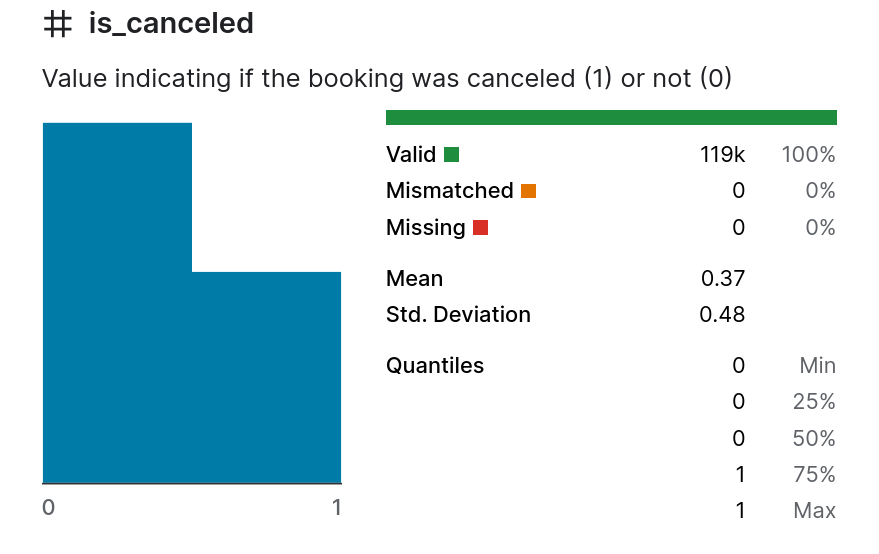

Разделение данных и построение baseline

Измерение качества константного предсказания (например, наиболее частотный класс для классификации, среднее/медиана для регрессии)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

dummy_clf = DummyClassifier(strategy="most_frequent")

In [ ]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [ ]:
f1_score(y_test, dummy_clf.predict(X_test))

0.0

In [ ]:
print(classification_report(y_test, dummy_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84     19011
           1       0.00      0.00      0.00      7158

    accuracy                           0.73     26169
   macro avg       0.36      0.50      0.42     26169
weighted avg       0.53      0.73      0.61     26169



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Результаты ожидаемы - DummyClassifier не чувствителен к меньшему классу

In [ ]:
def dummy_stategy(X, y, srategy):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
  dummy_clf = DummyClassifier(strategy=f"{srategy}")
  dummy_clf.fit(X_train, y_train)
  print (f'{srategy}')
  print(classification_report(y_test, dummy_clf.predict(X_test)))


In [ ]:
list_of_srategy = ['most_frequent', 'stratified', 'uniform', 'prior']
for srategy in list_of_srategy:
  dummy_stategy(X, y, srategy)

most_frequent
              precision    recall  f1-score   support

           0       0.73      1.00      0.84     19011
           1       0.00      0.00      0.00      7158

    accuracy                           0.73     26169
   macro avg       0.36      0.50      0.42     26169
weighted avg       0.53      0.73      0.61     26169

stratified
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     19011
           1       0.28      0.28      0.28      7158

    accuracy                           0.61     26169
   macro avg       0.50      0.50      0.50     26169
weighted avg       0.61      0.61      0.61     26169

uniform
              precision    recall  f1-score   support

           0       0.72      0.49      0.58     19011
           1       0.27      0.49      0.34      7158

    accuracy                           0.49     26169
   macro avg       0.49      0.49      0.46     26169
weighted avg       0.59      0.49      0.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

              precision    recall  f1-score   support

           0       0.73      1.00      0.84     19011
           1       0.00      0.00      0.00      7158

    accuracy                           0.73     26169
   macro avg       0.36      0.50      0.42     26169
weighted avg       0.53      0.73      0.61     26169



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Наилучшее значение для DummyClassifier = 0.73, но при это класс 1 абсолютно не детектируется. В дальнейшем будут рассмотрены класссификаторы, которые покажут более высокие значения (надеюсь)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

def objective(trial):
    max_depth = trial.suggest_int("rf_max_depth", 2, 18, log=True)
    max_samples = trial.suggest_float("rf_max_samples", 0.2, 1)
   
    rf_model = RandomForestClassifier(
      max_depth = max_depth,
      max_samples = max_samples,
      n_estimators = 50,
      random_state = 42)
    score = cross_val_score(rf_model, X_train, y_train, scoring='f1', n_jobs=-1, cv=3)
    f_metric = score.mean()
    return f_metric

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)


[I 2023-02-01 08:41:44,732] A new study created in memory with name: no-name-170e923b-fbd2-43c7-be04-374d4514acc3
/usr/local/lib/python3.8/dist-packages/optuna/trial/_trial.py:681: RuntimeWarning:

Inconsistent parameter values for distribution with name "rf_max_depth"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'log': True, 'step': 1, 'low': 2, 'high': 18}

[I 2023-02-01 08:41:54,137] Trial 0 finished with value: 0.5349922811007907 and parameters: {'rf_max_depth': 16, 'rf_max_samples': 0.6560270399293076}. Best is trial 0 with value: 0.5349922811007907.
/usr/local/lib/python3.8/dist-packages/optuna/trial/_trial.py:681: RuntimeWarning:

Inconsistent parameter values for distribution with name "rf_max_depth"! This might be a configuration mistake. Optuna allows to cal

In [ ]:
print(study.best_trial)

FrozenTrial(number=92, state=TrialState.COMPLETE, values=[0.5418108580720097], datetime_start=datetime.datetime(2023, 2, 1, 8, 50, 10, 691143), datetime_complete=datetime.datetime(2023, 2, 1, 8, 50, 16, 447170), params={'rf_max_depth': 18, 'rf_max_samples': 0.9993823353083647}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=18, log=True, low=2, step=1), 'rf_max_samples': FloatDistribution(high=1.0, log=False, low=0.2, step=None)}, trial_id=92, value=None)


In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

Валидация на отложенной выборке

In [ ]:
rf_model = RandomForestClassifier(
      max_depth = 18,
      max_samples = 0.99,
      n_estimators = 50,
      random_state = 42)

rf_model.fit(X_train, y_train)
print (classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88     19011
           1       0.73      0.46      0.57      7158

    accuracy                           0.81     26169
   macro avg       0.78      0.70      0.72     26169
weighted avg       0.80      0.81      0.79     26169



Субъективная оценка - на мой взгляд модель переобучилась, не смотря на то, что метрика f1 возросла, класс 1 все еще недостаточно хорошо распознается

План - в дальнейшем попробовать более сложную модель модели (xgboost)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

def objective(trial):
    max_depth = trial.suggest_int("rf_max_depth", 2, 18, log=True)
    min_samples_split = trial.suggest_int("rf_max_depth", 2, 8, log=True)
    min_samples_leaf = trial.suggest_int("rf_max_depth", 2, 8, log=True)
    max_samples = trial.suggest_float("rf_max_samples", 0.2, 1)
   
    rf_model = RandomForestClassifier(
      max_depth = max_depth,
      min_samples_split = min_samples_split,
      min_samples_leaf = min_samples_leaf,
      max_samples = max_samples,
      n_estimators = 50,
      random_state = 42)
    score = cross_val_score(rf_model, X_train, y_train, scoring='f1', n_jobs=-1, cv=3)
    f_metric = score.mean()
    return f_metric

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)


**Построение более сложной модели и ее интерпретация**

Построение более сложной модели с подбором гиперпараметров

Выбранная модель - xgboost

In [ ]:
import optuna 
from optuna import Trial, visualization

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

Подбор гиперпараметров с применением кросс валидации



1.   n_estimators - количество оцещиков
2.   max_depth - максимальная глубина базовых оценщиков
3.   reg_alpha - член регуляризации L1 на весах
4.   reg_lambda - член регуляризации L2 на весах
5.   gamma - минимальное снижение функции потерь, необходимое для дальнейшего разбиения узлов на листья 
6.   nthread - количество потоков, используемых для загрузки данных, когда применяется распараллеливание



In [ ]:
def objective(trial):

  param = {"n_estimators" : trial.suggest_int('n_estimators', 150, 500),
          'max_depth':trial.suggest_int('max_depth', 2, 15),
          'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
          'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
          'gamma':trial.suggest_int('gamma', 0, 5),
          'nthread' : -1
            }
    
  model = XGBClassifier(**param)
    
  return cross_val_score(model, X_train, y_train, scoring='f1', cv=3).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)


[I 2023-02-07 12:35:51,109] A new study created in memory with name: no-name-2f29d364-c4da-4948-aa8c-255db8a03b96
[I 2023-02-07 12:38:19,319] Trial 0 finished with value: 0.6215377087683523 and parameters: {'n_estimators': 298, 'max_depth': 12, 'reg_alpha': 3, 'reg_lambda': 0, 'gamma': 0}. Best is trial 0 with value: 0.6215377087683523.
[I 2023-02-07 12:40:32,459] Trial 1 finished with value: 0.5988491195207545 and parameters: {'n_estimators': 494, 'max_depth': 8, 'reg_alpha': 4, 'reg_lambda': 2, 'gamma': 3}. Best is trial 0 with value: 0.6215377087683523.
[I 2023-02-07 12:41:40,773] Trial 2 finished with value: 0.580905207082624 and parameters: {'n_estimators': 421, 'max_depth': 5, 'reg_alpha': 3, 'reg_lambda': 4, 'gamma': 3}. Best is trial 0 with value: 0.6215377087683523.
[I 2023-02-07 12:44:04,955] Trial 3 finished with value: 0.608773339729475 and parameters: {'n_estimators': 278, 'max_depth': 15, 'reg_alpha': 0, 'reg_lambda': 3, 'gamma': 4}. Best is trial 0 with value: 0.62153770

Trial 41 finished with value: 0.6244898553672543 and parameters: {'n_estimators': 373, 'max_depth': 12, 'reg_alpha': 3, 'reg_lambda': 2, 'gamma': 1}. Best is trial 41 with value: 0.6244898553672543

Trial 83 finished with value: 0.6246153877033117 and parameters: {'n_estimators': 378, 'max_depth': 12, 'reg_alpha': 3, 'reg_lambda': 2, 'gamma': 1}. Best is trial 83 with value: 0.6246153877033117.

In [ ]:
print(study.best_trial)

FrozenTrial(number=83, state=TrialState.COMPLETE, values=[0.6246153877033117], datetime_start=datetime.datetime(2023, 2, 7, 16, 2, 59, 569898), datetime_complete=datetime.datetime(2023, 2, 7, 16, 5, 57, 919946), params={'n_estimators': 378, 'max_depth': 12, 'reg_alpha': 3, 'reg_lambda': 2, 'gamma': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=150, step=1), 'max_depth': IntDistribution(high=15, log=False, low=2, step=1), 'reg_alpha': IntDistribution(high=5, log=False, low=0, step=1), 'reg_lambda': IntDistribution(high=5, log=False, low=0, step=1), 'gamma': IntDistribution(high=5, log=False, low=0, step=1)}, trial_id=83, value=None)


In [ ]:
visualization.plot_parallel_coordinate(study)

Обучение с лучшими подобранными значениями гиперпараметров


Измерение качества на отложенной выборке с использованием ранее выбранной метрики

In [ ]:
xgb_model = XGBClassifier(
      n_estimators = 378,
      max_depth = 12,
      reg_alpha = 3,
      reg_lambda = 2,
      gamma = 1,
      nthread = -1)

xgb_model.fit(X_train, y_train)
print (classification_report(y_test, xgb_model.predict(X_test)))

В рамках данного пункта приведена интерпретация модели, полученная в предыдущем пункте.

Критерии оценки:

- Получена интерпретация построенной модели, включая визуализации (коэффициенты/permutation importances/shap и тд)

- Приведено экспертное мнение о полученной интерпретации (вы, как эксперт в предметной области, можете оценить адекватность признаков и решений, принимаемых моделью, и выразить свое мнение в 1-2 предложении)

In [ ]:
xgb_model.feature_importances_

In [ ]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(X.feature_names[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [ ]:
perm_importance = permutation_importance(xgb_model, X_test, y_test)

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

SHAP

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_test)